In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
import torch
import random

In [2]:
#Set the seed
seed = 0
torch.manual_seed(seed)
np.random.seed(0)

In [3]:
class FNN(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.linears = nn.ModuleList([
            nn.Linear(layers[i],layers[i+1]) for i in range(len(layers)-1)
        ])
        self.activation = F.sigmoid
        for layer in self.linears:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
    def forward(self, x):
        for layer in self.linears[:-2]:
            x = self.activation(layer(x))
        return self.linears[-1](x)

In [4]:
class RefractionPINN(FNN):
    def __init__(self, n_output):
        super().__init__([1]+[64]*3+[n_output])

        
        
    def forward(self, x):
        x = super().forward(x)
        return x

In [5]:
def pinn_loss(x, y, t, save_loss=True):
       
        x_t = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        y_t = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]


        L_con = 0
        if t[0] == tmin:
            L_con = ((x[0]-x0)**2+(y[0] - y0)**2+(x[-1] - x1)**2+(y[-1] - y1)**2)
        refraction = n1 + (n2 - n1) * 0.5 * (1. - torch.cos(2. * np.pi * y))
        L_phys = ((x_t / T)**2 +(y_t / T)**2 - (c0 / refraction)**2).abs().square().mean()

        L_goal = 0
        #if t[-1] == tmax:
        L_goal = T
        L_con = loss_weights[0]*L_con
        L_phys = loss_weights[1]*L_phys
        L_goal = loss_weights[2]*L_goal
        #print(f"con: {L_con}, phys: {L_phys}, goal: {L_goal}")
        if save_loss:
            losses.append((L_con,L_phys,L_goal))
        return L_con + L_phys + L_goal
    

In [6]:
def sample_points():
    points = [tmin]
    points += [random.uniform(tmin,tmax) for _ in range(num_domain-2)]
    points += [tmax]
    points.sort()

    points_tensor = torch.tensor(points).reshape((num_domain, 1))
    points_tensor.requires_grad = True
    return points_tensor

In [7]:
def train(model, optimizer, steps):
    model.train()
    time_dom = sample_points()
    #print(f"...Adam")
    for n in range(n_adam):
        optimizer.zero_grad()

        if n % period == 0:
            time_dom = sample_points()
        u = model(time_dom)
        x, y = u[:,0], u[:,1]
        loss = pinn_loss(x, y, time_dom)
        loss.backward()
        optimizer.step()
        #if n % period == 0:
        #    print(f"ADAM Loss {n}/{n_adam}: \n{loss}\n_______________")
    def closure(time_dom, save_losses):
        optimizer.zero_grad()
        u = model(time_dom)
        x, y = u[:,0], u[:,1]
        loss = pinn_loss(x, y, time_dom)
        loss.backward()
        return loss
    #print("...L-BFGS")
    optimizer = torch.optim.LBFGS(list(model.parameters()) + [T], lr = lr)
    time_dom = torch.linspace(tmin,tmax,num_domain).reshape((num_domain,1))
    time_dom.requires_grad = True
    try:
        for n in range(n_lbfgs):
            optimizer.step(lambda: closure(time_dom,False))
            loss = closure(time_dom, True)
            #if n % period == 0:
            #    print(f"LBFGS Loss {n}/{n_lbfgs}: \n{loss}\n_______________")
    except KeyboardInterrupt:
        print("interrupted")
        pass

In [8]:
def plot_output(model):
    model.eval()
    time_dom = torch.linspace(tmin, tmax, num_domain).reshape((num_domain,1))
    with torch.no_grad():
        u = [model(t.reshape(1)).to(device="cpu") for t in time_dom]
    plt.subplot(1,2,1)
    #plt.plot(time_dom.detach().numpy(), [y[0] for y in u], label = "x")
    plt.plot([y[0] for y in u], [y[1] for y in u])
    plt.legend()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.subplot(1, 2, 2)
    plt.plot([x[0].detach().numpy() for x in losses], label="constraint")
    plt.plot([x[1].detach().numpy() for x in losses], label="physics")
    plt.plot([x[2].detach().numpy() for x in losses], label="goal")
    plt.plot([x[0].detach().numpy() + x[1].detach().numpy() + x[2].detach().numpy() for x in losses], label = "total loss")
    plt.semilogy()
    plt.legend()
    plt.suptitle("Learned function (left) and losses during training (right)")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

In [9]:
tmin, tmax = 0.0, 1.0
T = torch.tensor(1.0, requires_grad = True)
x0, y0 = 0., 0.
x1, y1 = 1., 1.
c0, n1, n2 = 1., 1., 2.
losses = []
x_t = None
y_t = None

In [10]:
n_output = 2
num_domain = 1000 
n_adam =  2000
lr = 1e-3
loss_weights = [1.,1.,0.01] 
period = 100
n_lbfgs = 1232

Training


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting


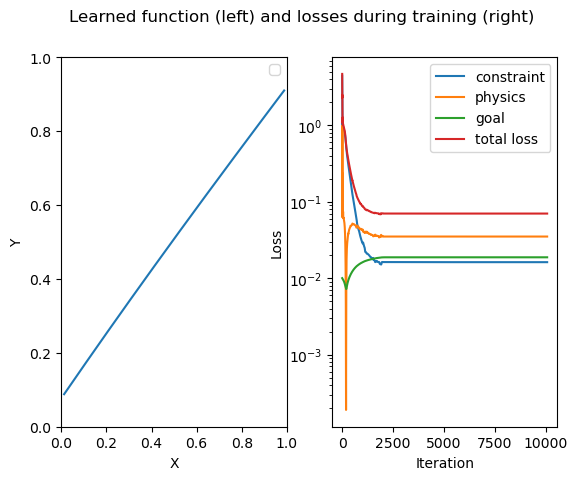

In [11]:

net = RefractionPINN(n_output)
net.to(device="cpu")
print("Training")

train(net, torch.optim.Adam(list(net.parameters())+ [T],lr = lr), n_adam)

print("Plotting")

plot_output(net)

# Brachistochrone curve

In [12]:
def pinn_loss_brach(x, y, t, save_loss=True):
       
        x_t = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        y_t = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]


        L_con = 0
        if t[0] == tmin:
            L_con = ((x[0]-x0)**2+(y[0] - y0)**2+(x[-1] - x1)**2+(y[-1] - y1)**2)
        
        L_phys = (g*y0-(g*y+0.5*((x_t/T)**2+(y_t/T)**2))).abs().square().mean()

        L_goal = 0
        #if t[-1] == tmax:
        L_goal = T
        L_con = loss_weights[0]*L_con
        L_phys = loss_weights[1]*L_phys
        L_goal = loss_weights[2]*L_goal
        #print(f"con: {L_con}, phys: {L_phys}, goal: {L_goal}")
        if save_loss:
            losses.append((L_con,L_phys,L_goal))
        return L_con + L_phys + L_goal

In [13]:
def trainBrach(model, optimizer, steps):
    model.train()
    time_dom = sample_points()
    #print(f"...Adam")
    for n in range(n_adam):
        optimizer.zero_grad()

        if n % period == 0:
            time_dom = sample_points()
        u = model(time_dom)
        x, y = u[:,0], u[:,1]
        loss = pinn_loss_brach(x, y, time_dom)
        loss.backward()
        optimizer.step()
        #if n % period == 0:
        #    print(f"ADAM Loss {n}/{n_adam}: \n{loss}\n_______________")
    def closure(time_dom, save_losses):
        optimizer.zero_grad()
        u = model(time_dom)
        x, y = u[:,0], u[:,1]
        loss = pinn_loss_brach(x, y, time_dom)
        loss.backward()
        return loss
    #print("...L-BFGS")
    optimizer = torch.optim.LBFGS(list(model.parameters()) + [T], lr = lr)
    time_dom = torch.linspace(tmin,tmax,num_domain).reshape((num_domain,1))
    time_dom.requires_grad = True
    try:
        for n in range(n_lbfgs):
            optimizer.step(lambda: closure(time_dom,False))
            loss = closure(time_dom, True)
            #if n % period == 0:
            #    print(f"LBFGS Loss {n}/{n_lbfgs}: \n{loss}\n_______________")
    except KeyboardInterrupt:
        print("interrupted")
        pass

In [14]:
tmin, tmax = 0.0, 1.0
T = torch.tensor(1.0, requires_grad = True)
x0, y0 = 0., 1.
x1, y1 = 1., 0.
c0, n1, n2 = 1., 1., 2.
losses = []
x_t = None
y_t = None
g = 9.8
n_output = 2
num_domain = 1000 
n_adam =  2000
lr = 1e-3
loss_weights = [1.,1.,0.01] 
period = 100
n_lbfgs = 2692

Training


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting


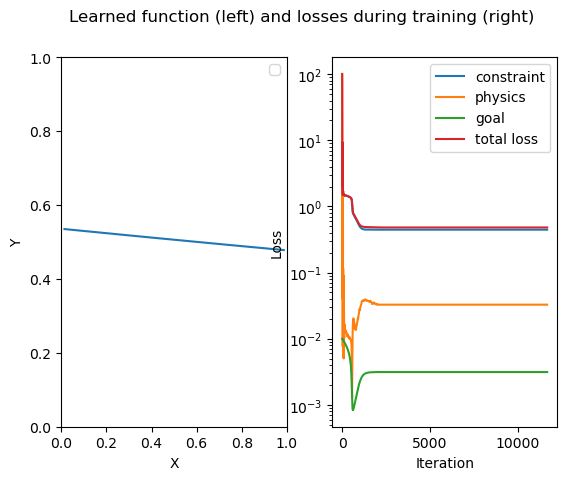

In [15]:
net = RefractionPINN(n_output)
net.to(device="cpu")
print("Training")

trainBrach(net, torch.optim.Adam(list(net.parameters())+ [T],lr = lr), n_adam)

print("Plotting")

plot_output(net)

In [16]:
tmin, tmax = 0.0, 1.0

x0, y0 = 0., 0.
x1, y1 = 1., 1.
c0, n1, n2 = 1., 1., 2.

x_t = None
y_t = None
n_output = 2
num_domain = 1000 

n_adam =  2000
lr = 1e-3
lc = [1., 5.]
lp = [1., 5.]
lg = [0.01, 0.1]
period = 100
n_lbfgs = 1232

Evaluating loss weights: 1.0, 1.0, 0.01 
Training


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting


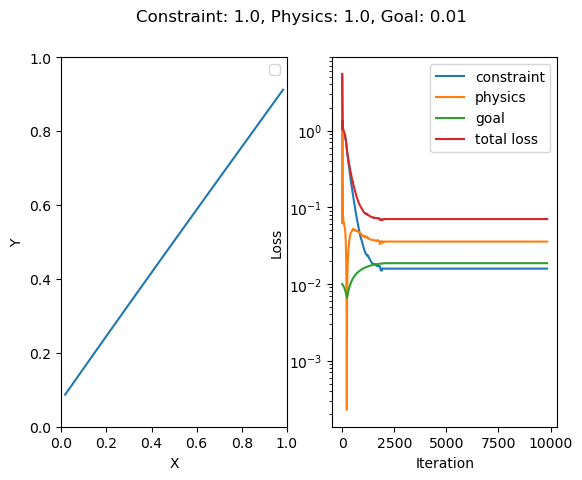

Evaluating loss weights: 1.0, 1.0, 0.1 
Training
Plotting


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


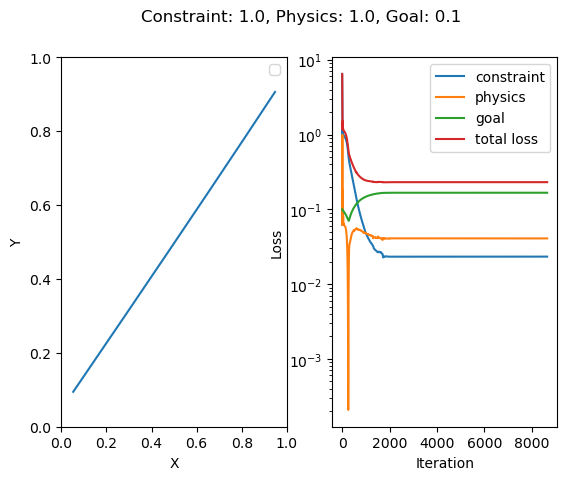

Evaluating loss weights: 1.0, 5.0, 0.01 
Training


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting


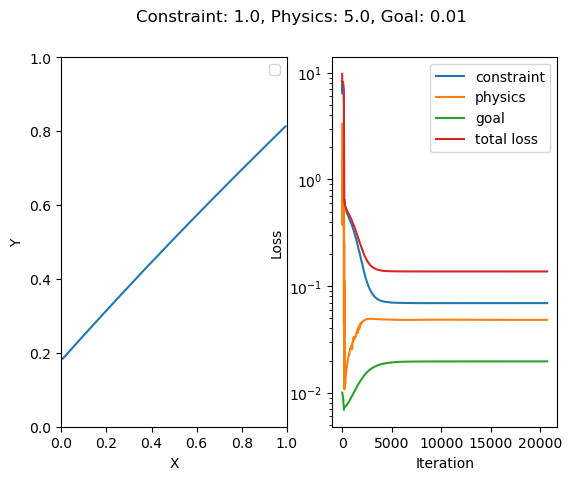

Evaluating loss weights: 1.0, 5.0, 0.1 
Training


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting


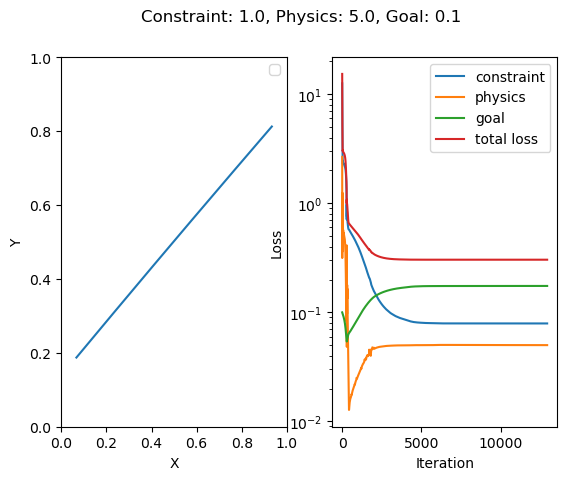

Evaluating loss weights: 5.0, 1.0, 0.01 
Training


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting


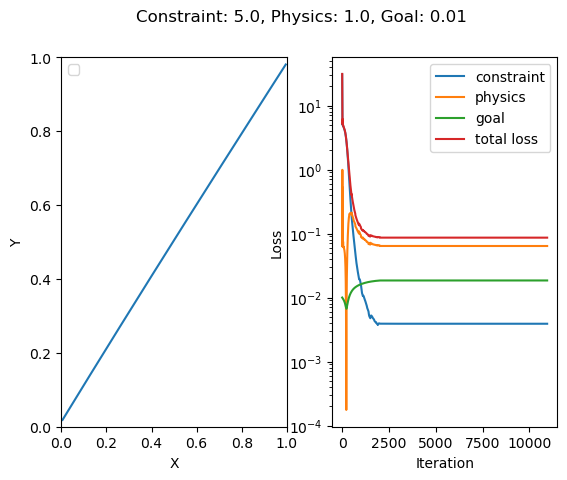

Evaluating loss weights: 5.0, 1.0, 0.1 
Training


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting


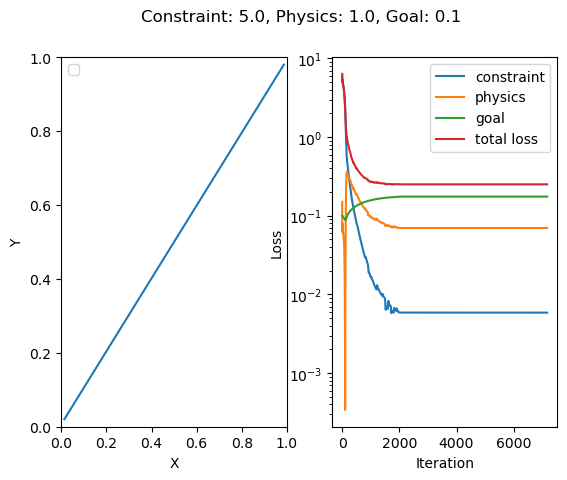

Evaluating loss weights: 5.0, 5.0, 0.01 
Training


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting


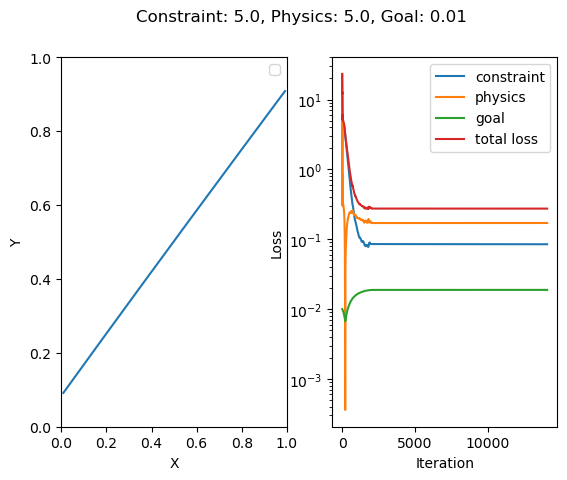

Evaluating loss weights: 5.0, 5.0, 0.1 
Training


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting


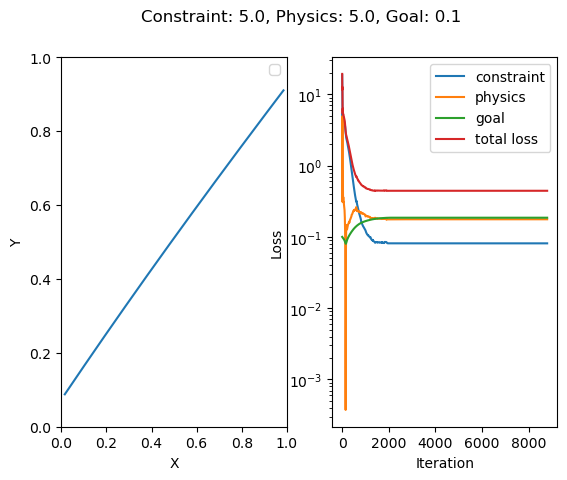

In [17]:
for i in lc:
    for j in lp:
        for k in lg:
            T = torch.tensor(1.0, requires_grad = True)
            losses = []
            print(f"Evaluating loss weights: {i}, {j}, {k} ")
            loss_weights = [i,j,k]
            net = RefractionPINN(n_output)
            net.to(device="cpu")
            print("Training")

            train(net, torch.optim.Adam(list(net.parameters())+ [T],lr = lr), n_adam)

            print("Plotting")

            net.eval()
            time_dom = torch.linspace(tmin, tmax, num_domain).reshape((num_domain,1))
            with torch.no_grad():
                u = [net(t.reshape(1)).to(device="cpu") for t in time_dom]
            plt.subplot(1,2,1)
            #plt.plot(time_dom.detach().numpy(), [y[0] for y in u], label = "x")
            plt.plot([y[0] for y in u], [y[1] for y in u])
            plt.legend()
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.subplot(1, 2, 2)
            plt.plot([x[0].detach().numpy() for x in losses], label="constraint")
            plt.plot([x[1].detach().numpy() for x in losses], label="physics")
            plt.plot([x[2].detach().numpy() for x in losses], label="goal")
            plt.plot([x[0].detach().numpy() + x[1].detach().numpy() + x[2].detach().numpy() for x in losses], label = "total loss")
            plt.semilogy()
            plt.legend()
            plt.suptitle(f"Constraint: {i}, Physics: {j}, Goal: {k}")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.show()


Now for the shortest path
Evaluating loss weights: 5.0, 1.0, 0.01 
Training


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting


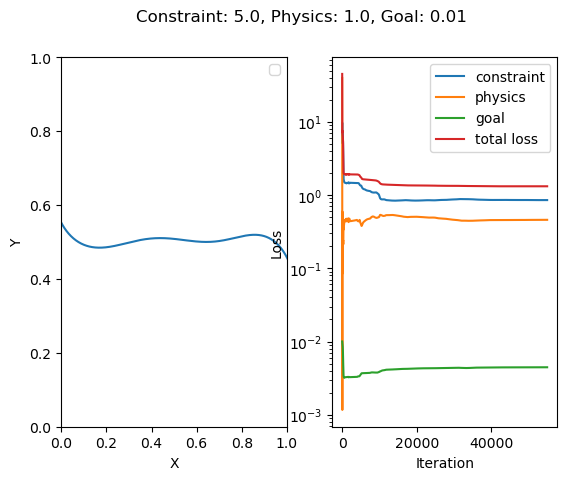

Evaluating loss weights: 5.0, 1.0, 0.1 
Training


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting


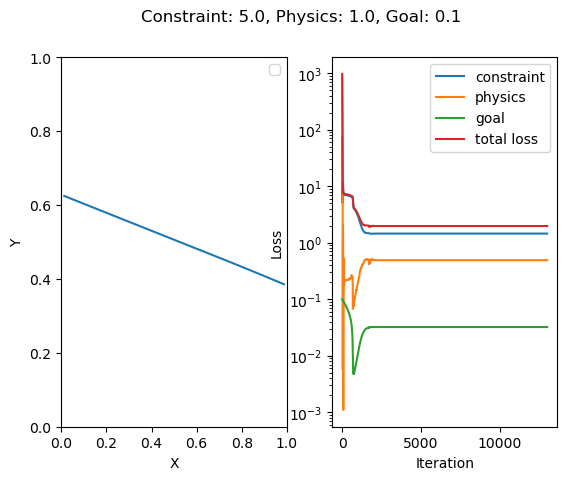

Evaluating loss weights: 5.0, 5.0, 0.01 
Training


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting


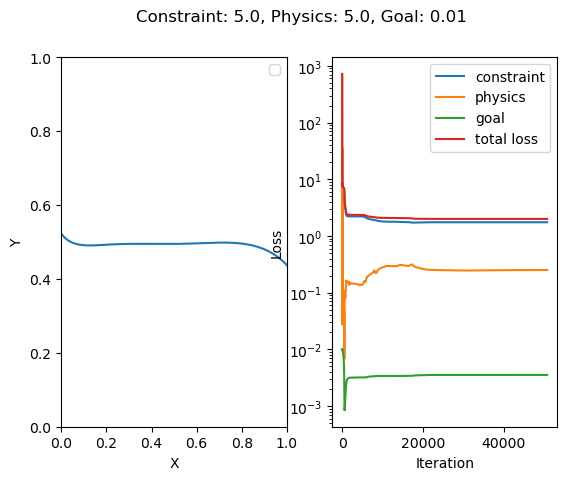

Evaluating loss weights: 5.0, 5.0, 0.1 
Training


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting


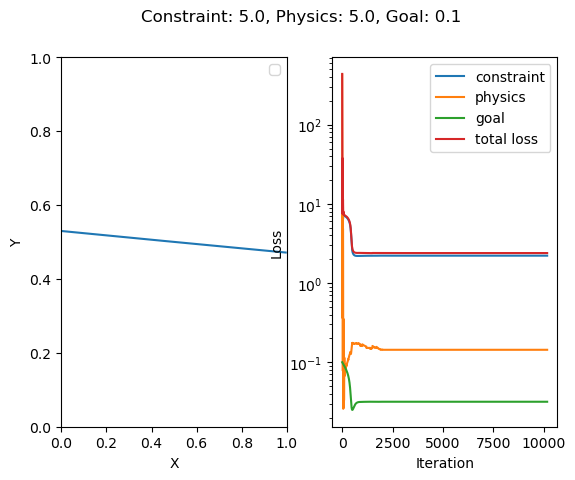

Evaluating loss weights: 1.0, 1.0, 0.01 
Training


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting


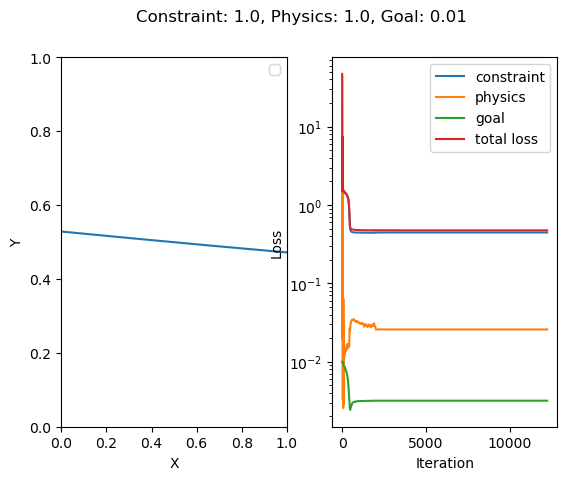

Evaluating loss weights: 1.0, 1.0, 0.1 
Training


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting


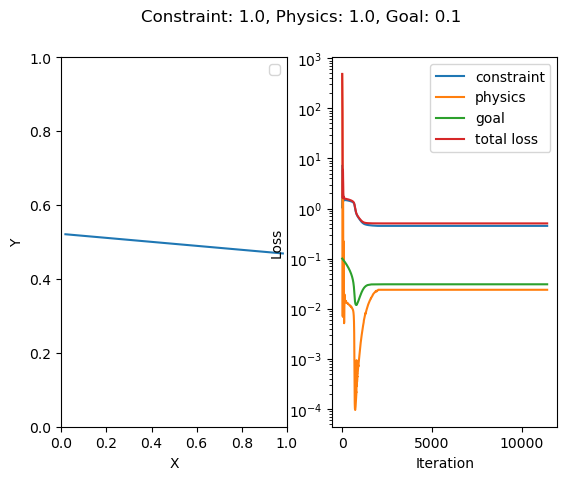

Evaluating loss weights: 1.0, 5.0, 0.01 
Training


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting


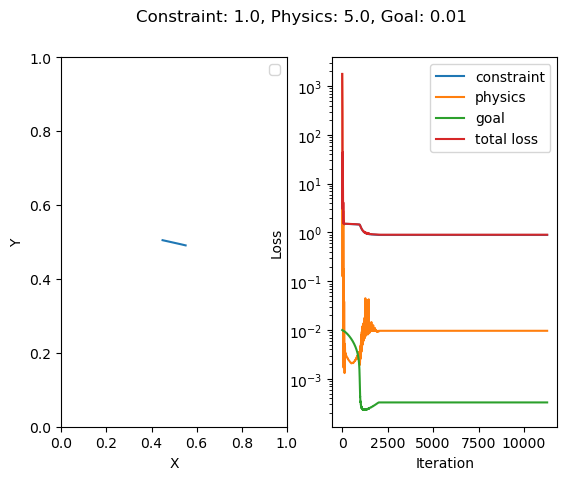

Evaluating loss weights: 1.0, 5.0, 0.1 
Training
Plotting


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


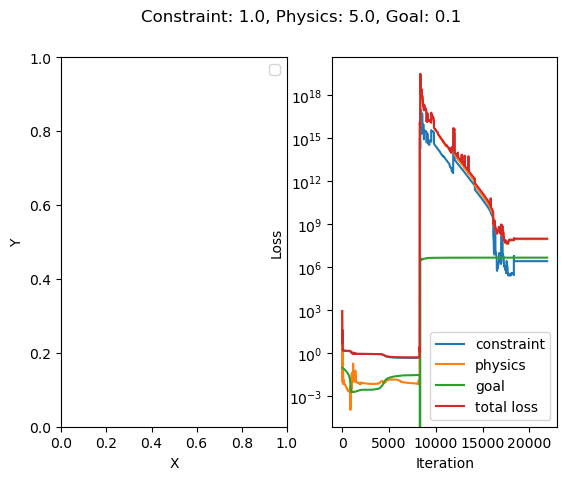

In [20]:
print("Now for the shortest path")
tmin, tmax = 0.0, 1.0

x0, y0 = 0., 1.
x1, y1 = 1., 0.
c0, n1, n2 = 1., 1., 2.

x_t = None
y_t = None
n_output = 2
num_domain = 1000 
g = 9.8
n_adam =  2000
lr = 1e-3
lc = [5., 1.]
lp = [1., 5.]
lg = [0.01, 0.1]
period = 100
n_lbfgs = 2692
for i in lc:
    for j in lp:
        for k in lg:
            T = torch.tensor(1.0, requires_grad = True)
            losses = []
            print(f"Evaluating loss weights: {i}, {j}, {k} ")
            loss_weights = [i,j,k]
            net = RefractionPINN(n_output)
            net.to(device="cpu")
            print("Training")

            trainBrach(net, torch.optim.Adam(list(net.parameters())+ [T],lr = lr), n_adam)

            print("Plotting")

            net.eval()
            time_dom = torch.linspace(tmin, tmax, num_domain).reshape((num_domain,1))
            with torch.no_grad():
                u = [net(t.reshape(1)).to(device="cpu") for t in time_dom]
            plt.subplot(1,2,1)
            #plt.plot(time_dom.detach().numpy(), [y[0] for y in u], label = "x")
            plt.plot([y[0] for y in u], [y[1] for y in u])
            plt.legend()
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.subplot(1, 2, 2)
            plt.plot([x[0].detach().numpy() for x in losses], label="constraint")
            plt.plot([x[1].detach().numpy() for x in losses], label="physics")
            plt.plot([x[2].detach().numpy() for x in losses], label="goal")
            plt.plot([x[0].detach().numpy() + x[1].detach().numpy() + x[2].detach().numpy() for x in losses], label = "total loss")
            plt.semilogy()
            plt.legend()
            plt.suptitle(f"Constraint: {i}, Physics: {j}, Goal: {k}")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.show()